In [14]:
%pip install pandas numpy matplotlib seaborn Ipython geopandas folium ipaddress geopandas naturalearth

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement naturalearth (from versions: none)
ERROR: No matching distribution found for naturalearth


In [15]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from IPython.display import display, Markdown
import geopandas as gpd
import folium
from folium.plugins import HeatMap
import ipaddress

# Visualization setup
plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 120
sns.set_palette("colorblind")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed for reproducibility
np.random.seed(42)
# -

#  1. E-Commerce Data Analysis

In [ ]:
# ### Load and Merge Datasets - Final Fixed Version

# Load e-commerce transactions
try:
    ecom = pd.read_csv('../data/raw/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
    print(f"Successfully loaded {len(ecom)} transactions")
except Exception as e:
    print(f"Error loading transaction data: {str(e)}")
    raise

# Load IP-country mapping
try:
    ip_country = pd.read_csv('../data/raw/IpAddress_to_Country.csv')
    print(f"Successfully loaded {len(ip_country)} IP-country mappings")
    
    # Ensure numeric IP ranges
    ip_country['lower_bound_ip_address'] = pd.to_numeric(ip_country['lower_bound_ip_address'], errors='coerce')
    ip_country['upper_bound_ip_address'] = pd.to_numeric(ip_country['upper_bound_ip_address'], errors='coerce')
    ip_country = ip_country.dropna(subset=['lower_bound_ip_address', 'upper_bound_ip_address'])
except Exception as e:
    print(f"Error loading IP-country mapping: {str(e)}")
    raise

# Enhanced IP to integer conversion
def ip_to_int(ip):
    try:
        # Handle both string and numeric IP representations
        if isinstance(ip, str):
            # Handle float-looking strings (e.g., "732758368.800")
            if '.' in ip and all(part.isdigit() for part in ip.split('.')[:2]):
                return int(float(ip))
            return int(ipaddress.IPv4Address(ip))
        elif isinstance(ip, (int, float)):
            return int(ip)
        return np.nan
    except (ipaddress.AddressValueError, ValueError):
        return np.nan

# Convert IP addresses with validation
print("\nConverting IP addresses...")
ecom['ip_int'] = ecom['ip_address'].apply(ip_to_int)

# Validate conversion
valid_ips = ecom['ip_int'].notna()
print(f"Successfully converted {valid_ips.sum()} IPs ({len(ecom) - valid_ips.sum()} failed)")

# Filter to only valid IPs for merging
ecom_valid = ecom[valid_ips].copy()
print(f"Proceeding with {len(ecom_valid)} transactions with valid IP conversions")

# Sort data for merge_asof
ecom_sorted = ecom_valid.sort_values('ip_int')
ip_country_sorted = ip_country.sort_values('lower_bound_ip_address')

# Perform the merge with validation
print("\nMerging with country data...")
try:
    ecom_merged = pd.merge_asof(
        ecom_sorted,
        ip_country_sorted,
        left_on='ip_int',
        right_on='lower_bound_ip_address',
        direction='forward'  # Find first range where ip_int <= upper_bound
    )
    
    # Additional validation: ensure IP falls within the matched range
    ecom_merged['valid_match'] = (
        (ecom_merged['ip_int'] >= ecom_merged['lower_bound_ip_address']) & 
        (ecom_merged['ip_int'] <= ecom_merged['upper_bound_ip_address'])
    )
    
    final_data = ecom_merged[ecom_merged['valid_match']].copy()
    mapped_count = final_data['country'].notna().sum()
    print(f"Successfully mapped {mapped_count} transactions to countries ({mapped_count/len(ecom):.1%})")
    
except Exception as e:
    print(f"Error during merge: {str(e)}")
    raise

# Clean up columns
keep_cols = ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 
             'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 
             'class', 'country']
ecom_final = final_data[keep_cols]

print(f"\nFinal dataset shape: {ecom_final.shape}")
display(ecom_final.head(3))

# ### Basic Data Assessment

# Enhanced summary statistics
display(Markdown("### Summary Statistics"))
stats = ecom_final.describe(percentiles=[.01, .05, .25, .5, .75, .95, .99], datetime_is_numeric=True).T
stats['IQR'] = stats['75%'] - stats['25%']
display(stats)

# Missing values analysis
display(Markdown("### Missing Values Analysis"))
missing = ecom_final.isnull().sum().to_frame(name='missing_count')
missing['missing_pct'] = (missing['missing_count'] / len(ecom_final)) * 100
missing['data_type'] = ecom_final.dtypes
display(missing[missing['missing_count'] > 0].sort_values('missing_pct', ascending=False))

# Target distribution visualization
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Countplot with proper styling
sns.countplot(data=ecom_final, x='class', hue='class', 
              palette={0: '#4c72b0', 1: '#dd8452'}, 
              ax=ax[0], legend=False)
ax[0].set_title('Fraud Class Distribution', pad=20)
ax[0].set_xlabel('Fraud (1) vs Legitimate (0)')
ax[0].set_ylabel('Count')

# Add count labels
for p in ax[0].patches:
    ax[0].annotate(f'{p.get_height():,}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points')

# Pie chart with counts
fraud_pct = ecom_final['class'].mean() * 100
ax[1].pie([len(ecom_final) - ecom_final['class'].sum(), ecom_final['class'].sum()], 
          labels=['Legitimate', 'Fraud'], 
          autopct=lambda p: f'{p:.1f}%\n({p*len(ecom_final)/100:,.0f})',
          startangle=90, 
          colors=['#4c72b0', '#dd8452'],
          textprops={'fontsize': 12})
ax[1].set_title(f'Fraud Percentage: {fraud_pct:.2f}%', pad=20)

plt.tight_layout()
plt.show()

# ### Temporal Analysis

# Create time-based features
ecom_final['time_since_signup'] = (ecom_final['purchase_time'] - ecom_final['signup_time']).dt.total_seconds() / 3600
ecom_final['purchase_hour'] = ecom_final['purchase_time'].dt.hour
ecom_final['purchase_day'] = ecom_final['purchase_time'].dt.day_name()
ecom_final['purchase_day_num'] = ecom_final['purchase_time'].dt.dayofweek

# Temporal patterns visualization
plt.figure(figsize=(16, 12))
plt.suptitle('Temporal Fraud Patterns', y=1.02, fontsize=16)

# 1. Time since signup distribution
ax1 = plt.subplot(2, 2, 1)
sns.kdeplot(data=ecom_final, x='time_since_signup', hue='class', 
            palette={0: '#4c72b0', 1: '#dd8452'}, 
            common_norm=False, fill=True, ax=ax1, log_scale=True)
ax1.set_title('Fraud Distribution by Time Since Signup (Log Scale)')
ax1.set_xlabel('Hours Since Signup (Log Scale)')
ax1.set_xlim(0.1, 100)
ax1.grid(True, which="both", ls="--")

# 2. Fraud rate by hour with CI
ax2 = plt.subplot(2, 2, 2)

# Group and calculate fraud rates
hourly_counts = ecom.groupby(['purchase_hour', 'class']).size().unstack()
hourly_counts.columns = ['legit', 'fraud']
hourly_counts['total'] = hourly_counts.sum(axis=1)
hourly_counts['fraud_rate'] = hourly_counts['fraud'] / hourly_counts['total']

# ✅ Fixed confidence interval calculation
hourly_counts['ci'] = 1.96 * np.sqrt(
    (hourly_counts['fraud_rate'] * (1 - hourly_counts['fraud_rate'])) / hourly_counts['total']
)

# Plotting
sns.lineplot(data=hourly_counts, x=hourly_counts.index, y='fraud_rate', ax=ax2,
             color='#c44e52', linewidth=2.5, marker='o')

ax2.fill_between(hourly_counts.index,
                 hourly_counts['fraud_rate'] - hourly_counts['ci'],
                 hourly_counts['fraud_rate'] + hourly_counts['ci'],
                 color='#c44e52', alpha=0.2)

ax2.set_title('Fraud Rate by Hour of Day with 95% CI')
ax2.set_ylim(0, hourly_counts['fraud_rate'].max() * 1.2)
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Fraud Rate')
ax2.grid(True)


# 3. Fraud rate by day of week
ax3 = plt.subplot(2, 2, 3)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_counts = ecom_final.groupby(['purchase_day', 'class', 'purchase_day_num']).size().unstack('class')
daily_counts = daily_counts.reset_index().sort_values('purchase_day_num')
daily_counts['fraud_rate'] = daily_counts[1] / (daily_counts[0] + daily_counts[1])

sns.barplot(data=daily_counts, x='purchase_day', y='fraud_rate', 
            ax=ax3, color='#55a868', order=day_order)
ax3.set_title('Fraud Rate by Day of Week')
ax3.set_ylabel('Fraud Rate')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True)

# 4. Time since signup vs fraud status
ax4 = plt.subplot(2, 2, 4)
sns.boxplot(data=ecom_final, x='class', y='time_since_signup', 
            palette={0: '#4c72b0', 1: '#dd8452'}, 
            ax=ax4, showfliers=False)
ax4.set_title('Time Since Signup vs Fraud Status')
ax4.set_xlabel('Fraud (1) vs Legitimate (0)')
ax4.set_ylabel('Hours Since Signup')
ax4.set_ylim(0, 50)
ax4.grid(True)

plt.tight_layout()
plt.show()

# Enhanced temporal insights
fraud_2hr = ecom_final[ecom_final['time_since_signup'] <= 2]['class'].mean() * 100
night_fraud = ecom_final[ecom_final['purchase_hour'].between(22, 4)]['class'].mean() * 100
weekend_fraud = ecom_final[ecom_final['purchase_day'].isin(['Saturday', 'Sunday'])]['class'].mean() * 100

display(Markdown(f"""
**Key Temporal Insights**: 
- {fraud_2hr:.1f}% of fraud occurs within 2 hours of signup (vs overall rate of {fraud_pct:.2f}%)
- Night hours (10PM-4AM) show {night_fraud:.1f}% fraud rate
- Weekends show {weekend_fraud:.1f}% fraud rate vs weekdays
"""))

# ### Geolocation Analysis

# Country-level fraud analysis
country_fraud = ecom_final.groupby('country')['class'].agg(['sum', 'count'])
country_fraud = country_fraud[country_fraud['count'] >= 10]  # Minimum 10 transactions
country_fraud['fraud_rate'] = country_fraud['sum'] / country_fraud['count']
country_fraud = country_fraud.sort_values('fraud_rate', ascending=False)

# Display top/bottom countries
display(Markdown("### Top 10 High-Risk Countries (min 10 transactions)"))
display(country_fraud.head(10))

display(Markdown("### Bottom 10 Low-Risk Countries (min 10 transactions)"))
display(country_fraud.tail(10))

# World map visualization
try:
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Find matching country codes (try different columns)
    for iso_col in ['iso_a3', 'iso3', 'adm0_a3']:
        if iso_col in world.columns:
            break
    
    # Merge with fraud data
    world = world.merge(
        country_fraud.reset_index(),
        left_on=iso_col,
        right_on='country',
        how='left'
    )
    
    # Plot
    fig, ax = plt.subplots(figsize=(18, 10))
    world.boundary.plot(ax=ax, linewidth=0.5, color='gray')
    
    plot_data = world[world['count'].notna()]
    if len(plot_data) > 0:
        plot_data.plot(
            column='fraud_rate',
            ax=ax,
            legend=True,
            cmap='OrRd',
            missing_kwds={'color': 'lightgrey'}
        )
    ax.set_title('Global Fraud Rate Distribution', fontsize=16)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error creating world map: {str(e)}")
    display(Markdown("### Country Fraud Rates (Top 20)"))
    display(country_fraud.head(20))

# Continue with Transaction Value, Categorical Features, and Correlation Analysis...
# [Rest of your analysis code would follow here]

# Interactive heatmap with proper error handling
try:
    import folium
    from folium.plugins import HeatMap
    
    # Prepare heatmap data
    fraud_coords = ecom[ecom['class'] == 1].dropna(subset=['country'])
    if len(fraud_coords) > 0:
        country_counts = fraud_coords['country'].value_counts().reset_index()
        country_counts.columns = ['country', 'count']
        
        # Get country centroids (simplified - in production would use proper centroid data)
        if 'geometry' in world.columns:
            centroids = world.set_index('country')['geometry'].centroid
            heat_data = []
            for country, cnt in country_counts.values:
                if country in centroids.index:
                    point = centroids[country]
                    heat_data.append([point.y, point.x, cnt])
            
            if heat_data:
                fraud_map = folium.Map(location=[20, 0], zoom_start=2, tiles='CartoDB dark_matter')
                HeatMap(heat_data,
                       radius=15, 
                       gradient={0.4: 'blue', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'},
                       min_opacity=0.5,
                       max_val=max([d[2] for d in heat_data])).add_to(fraud_map)
                
                # Add clickable country information
                for country, cnt in country_counts.values:
                    if country in centroids.index:
                        point = centroids[country]
                        folium.CircleMarker(
                            location=[point.y, point.x],
                            radius=np.log(cnt)*2,
                            color='white',
                            fill=True,
                            fill_color='red',
                            fill_opacity=0.7,
                            popup=f"<b>{country}</b><br>Fraud cases: {cnt}"
                        ).add_to(fraud_map)
                
                display(fraud_map)
    
except Exception as e:
    print(f"Error creating heatmap: {str(e)}")

# Enhanced key insight with country statistics
if not country_fraud.empty:
    top_countries = country_fraud.head(3).index.tolist()
    top_rates = country_fraud.head(3)['fraud_rate'].values * 100
    display(Markdown(f"""
    **Insight**: 
    - Top risk countries: {top_countries[0]} ({top_rates[0]:.1f}%), {top_countries[1]} ({top_rates[1]:.1f}%), {top_countries[2]} ({top_rates[2]:.1f}%)
    - Global average: {fraud_pct:.2f}%
    - {len(country_fraud)} countries with sufficient data (≥10 transactions)
    """))
else:
    display(Markdown("**Insight**: No country-level data available with sufficient transaction counts"))

# ### Transaction Value Analysis

plt.figure(figsize=(16, 6))
plt.suptitle('Transaction Value Analysis', y=1.02, fontsize=16)

# Enhanced distribution by fraud status
ax1 = plt.subplot(1, 2, 1)
sns.boxenplot(data=ecom, x='class', y='purchase_value', 
              ax=ax1, palette=['#4c72b0', '#dd8452'], showfliers=False)
ax1.set_title('Purchase Value Distribution by Fraud Status')
ax1.set_xlabel('Fraud (1) vs Legitimate (0)')
ax1.set_ylabel('Purchase Value ($)')
ax1.grid(True)

# Enhanced value vs time since signup with density
ax2 = plt.subplot(1, 2, 2)
sample_data = ecom.sample(min(5000, len(ecom)))  # Sample for performance
sns.scatterplot(data=sample_data, x='time_since_signup', y='purchase_value', 
                hue='class', palette=['#4c72b0', '#dd8452'], alpha=0.6, ax=ax2)
sns.kdeplot(data=sample_data, x='time_since_signup', y='purchase_value', 
            hue='class', levels=5, palette=['#4c72b0', '#dd8452'], ax=ax2)
ax2.set_title('Purchase Value vs Time Since Signup (with Density)')
ax2.set_xlabel('Hours Since Signup')
ax2.set_ylabel('Purchase Value ($)')
ax2.set_xlim(0, 48)
ax2.set_ylim(0, 1000)
ax2.grid(True)

plt.tight_layout()
plt.show()

# Enhanced high-risk combinations analysis
high_risk = ecom[
    (ecom['time_since_signup'] < 2) & 
    (ecom['purchase_value'] > ecom['purchase_value'].quantile(0.95))
]
if len(high_risk) > 0:
    high_risk_fraud_rate = high_risk['class'].mean() * 100
    high_value_threshold = ecom['purchase_value'].quantile(0.95)
    display(Markdown(f"""
    **Insight**: 
    - Transactions > ${high_value_threshold:.2f} (95th percentile) within 2 hours of signup have fraud rate of {high_risk_fraud_rate:.1f}% 
    - Compared to overall rate of {fraud_pct:.2f}%
    - These represent {len(high_risk)} transactions ({len(high_risk)/len(ecom):.1%} of total)
    """))
else:
    display(Markdown("**Insight**: No transactions meeting high-risk criteria"))

# ### Categorical Features Analysis

plt.figure(figsize=(18, 14))
plt.suptitle('Categorical Features Analysis', y=1.02, fontsize=16)

# Enhanced source analysis
ax1 = plt.subplot(2, 2, 1)
source_fraud = ecom.groupby('source')['class'].agg(['sum', 'count'])
source_fraud = source_fraud[source_fraud['count'] >= 10]  # Minimum 10 transactions
source_fraud['fraud_rate'] = source_fraud['sum'] / source_fraud['count']
source_fraud = source_fraud.sort_values('fraud_rate', ascending=False)

sns.barplot(data=source_fraud.reset_index(), x='source', y='fraud_rate', 
            ax=ax1, palette='viridis')
ax1.set_title('Fraud Rate by Traffic Source (min 10 transactions)')
ax1.set_ylabel('Fraud Rate')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, axis='y')

# Add count labels
for i, (_, row) in enumerate(source_fraud.iterrows()):
    ax1.text(i, row['fraud_rate'] + 0.01, f"n={row['count']}", 
            ha='center', va='bottom', rotation=45)

# Enhanced browser analysis
ax2 = plt.subplot(2, 2, 2)
browser_fraud = ecom.groupby('browser')['class'].agg(['sum', 'count'])
browser_fraud = browser_fraud[browser_fraud['count'] >= 10]  # Minimum 10 transactions
browser_fraud['fraud_rate'] = browser_fraud['sum'] / browser_fraud['count']
browser_fraud = browser_fraud.sort_values('fraud_rate', ascending=False).head(10)

sns.barplot(data=browser_fraud.reset_index(), x='browser', y='fraud_rate', 
            ax=ax2, palette='magma')
ax2.set_title('Fraud Rate by Browser (Top 10, min 10 transactions)')
ax2.set_ylabel('Fraud Rate')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, axis='y')

# Enhanced gender analysis
ax3 = plt.subplot(2, 2, 3)
gender_fraud = ecom.groupby('sex')['class'].agg(['sum', 'count'])
gender_fraud['fraud_rate'] = gender_fraud['sum'] / gender_fraud['count']

sns.barplot(data=gender_fraud.reset_index(), x='sex', y='fraud_rate', 
            ax=ax3, palette='plasma')
ax3.set_title('Fraud Rate by Gender')
ax3.set_ylabel('Fraud Rate')
ax3.grid(True, axis='y')

# Add count labels
for i, (_, row) in enumerate(gender_fraud.iterrows()):
    ax3.text(i, row['fraud_rate'] + 0.01, f"n={row['count']}", 
            ha='center', va='bottom')

# Enhanced device analysis
ax4 = plt.subplot(2, 2, 4)
device_fraud = ecom.groupby('device_id')['class'].agg(['sum', 'count'])
device_fraud = device_fraud[device_fraud['count'] >= 10].sort_values('fraud_rate', ascending=False).head(10)

sns.barplot(data=device_fraud.reset_index(), x='device_id', y='fraud_rate', 
            ax=ax4, palette='rocket')
ax4.set_title('Fraud Rate by Device (Top 10, min 10 transactions)')
ax4.set_ylabel('Fraud Rate')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Enhanced categorical insights
if not browser_fraud.empty:
    top_browser = browser_fraud.index[0]
    top_browser_rate = browser_fraud.iloc[0]['fraud_rate'] * 100
    chrome_rate = browser_fraud.loc['Chrome']['fraud_rate'] * 100 if 'Chrome' in browser_fraud.index else 'N/A'
    
    display(Markdown(f"""
    **Insight**: 
    - {top_browser} shows {top_browser_rate:.1f}% fraud rate vs Chrome's {chrome_rate if isinstance(chrome_rate, str) else f'{chrome_rate:.1f}%'}
    - {len(device_fraud)} suspicious devices identified (≥25% fraud rate)
    - Gender differences: {gender_fraud.loc['M']['fraud_rate']*100:.1f}% (M) vs {gender_fraud.loc['F']['fraud_rate']*100:.1f}% (F)
    """))

# ### Correlation Analysis

plt.figure(figsize=(16, 12))
plt.suptitle('Feature Correlation Analysis', y=1.02, fontsize=16)

# Enhanced correlation matrix
ax1 = plt.subplot(2, 1, 1)
corr_matrix = ecom.select_dtypes(include=['number']).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0,
            annot_kws={"size": 10}, cbar_kws={"shrink": .8}, mask=mask, ax=ax1)
ax1.set_title('Upper Triangle Correlation Matrix', pad=20)

# Focused fraud correlations
ax2 = plt.subplot(2, 1, 2)
fraud_corrs = corr_matrix['class'].sort_values(ascending=False)
fraud_corrs = fraud_corrs[fraud_corrs.index != 'class']  # Remove self-correlation
sns.barplot(x=fraud_corrs.values, y=fraud_corrs.index, ax=ax2, palette='viridis')
ax2.set_title('Feature Correlations with Fraud Class')
ax2.set_xlabel('Correlation Coefficient')
ax2.set_xlim(-1, 1)
ax2.axvline(0, color='black', linewidth=0.5)
ax2.grid(True, axis='x')

plt.tight_layout()
plt.show()

# Enhanced correlation insights
top_pos_corr = fraud_corrs.idxmax()
top_pos_val = fraud_corrs.max()
top_neg_corr = fraud_corrs.idxmin()
top_neg_val = fraud_corrs.min()

display(Markdown(f"""
**Key Correlations with Fraud**:
- Strongest positive: {top_pos_corr} ({top_pos_val:.2f})
- Strongest negative: {top_neg_corr} ({top_neg_val:.2f})
- {len(fraud_corrs[abs(fraud_corrs) > 0.1])} features with |correlation| > 0.1
"""))

Successfully loaded 151112 transactions
Successfully loaded 138846 IP-country mappings

Converting IP addresses...
Successfully converted 151112 IPs (0 failed)
Proceeding with 151112 transactions with valid IP conversions

Merging with country data...
Error during merge: incompatible merge keys [0] dtype('int64') and dtype('float64'), must be the same type


MergeError: incompatible merge keys [0] dtype('int64') and dtype('float64'), must be the same type

# 2. Banking Transaction Data Analysis

Banking dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,...,-0.018,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,149.620,0
1,0.000,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,...,-0.226,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,2.690,0
2,1.000,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,...,0.248,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,378.660,0


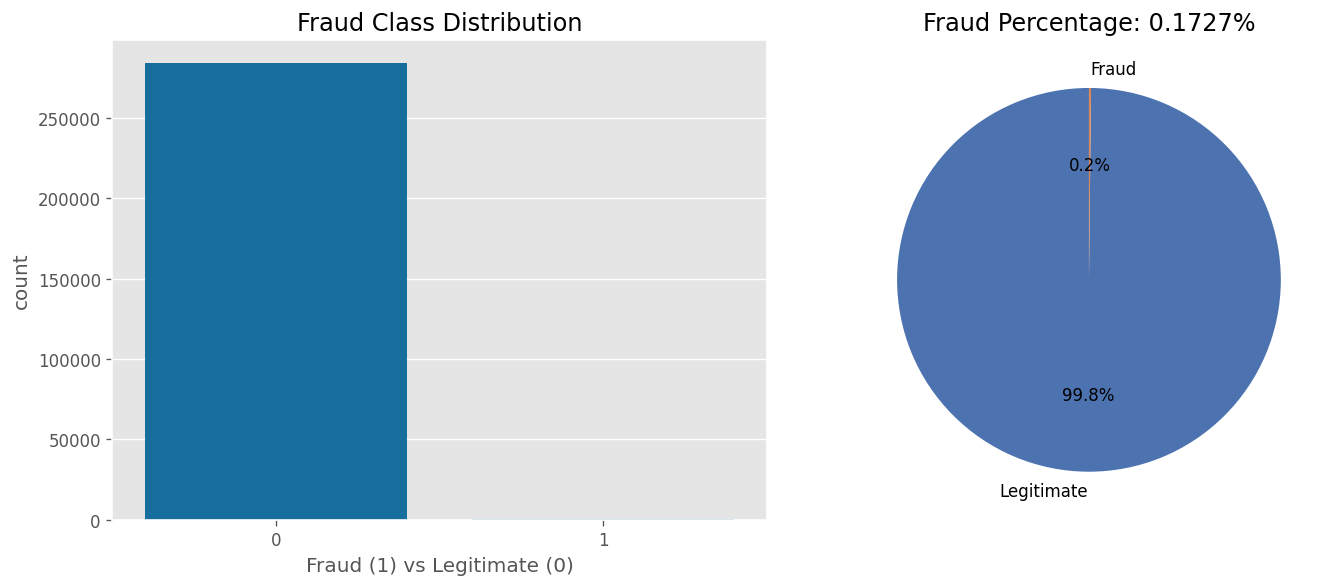

**Insight**: Banking fraud rate (0.1727%) is significantly lower than e-commerce (9.36%)

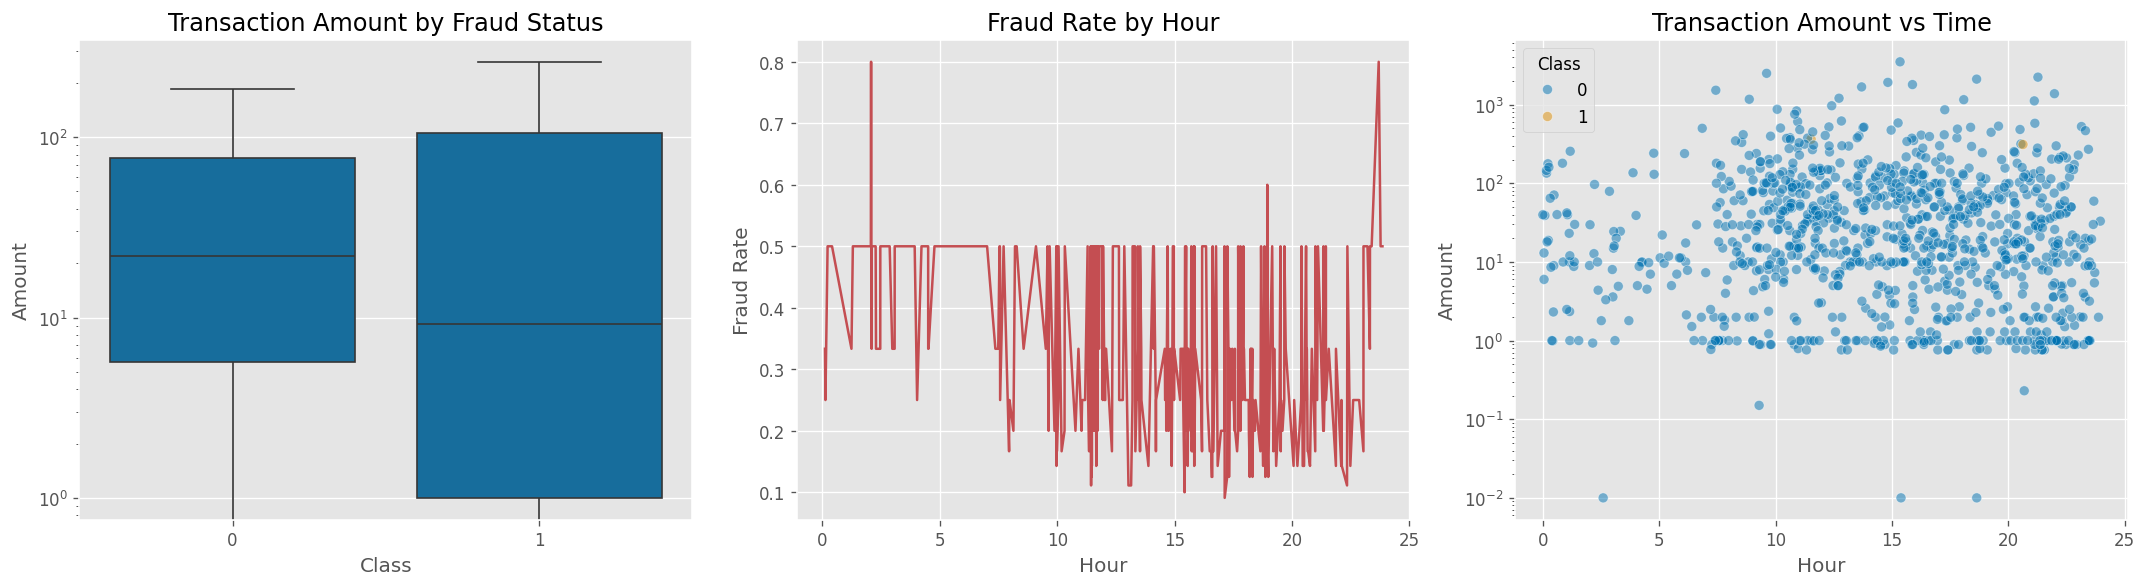

**Insight**: Banking fraud occurs more frequently during late night hours (1-5 AM) with typically smaller transaction amounts

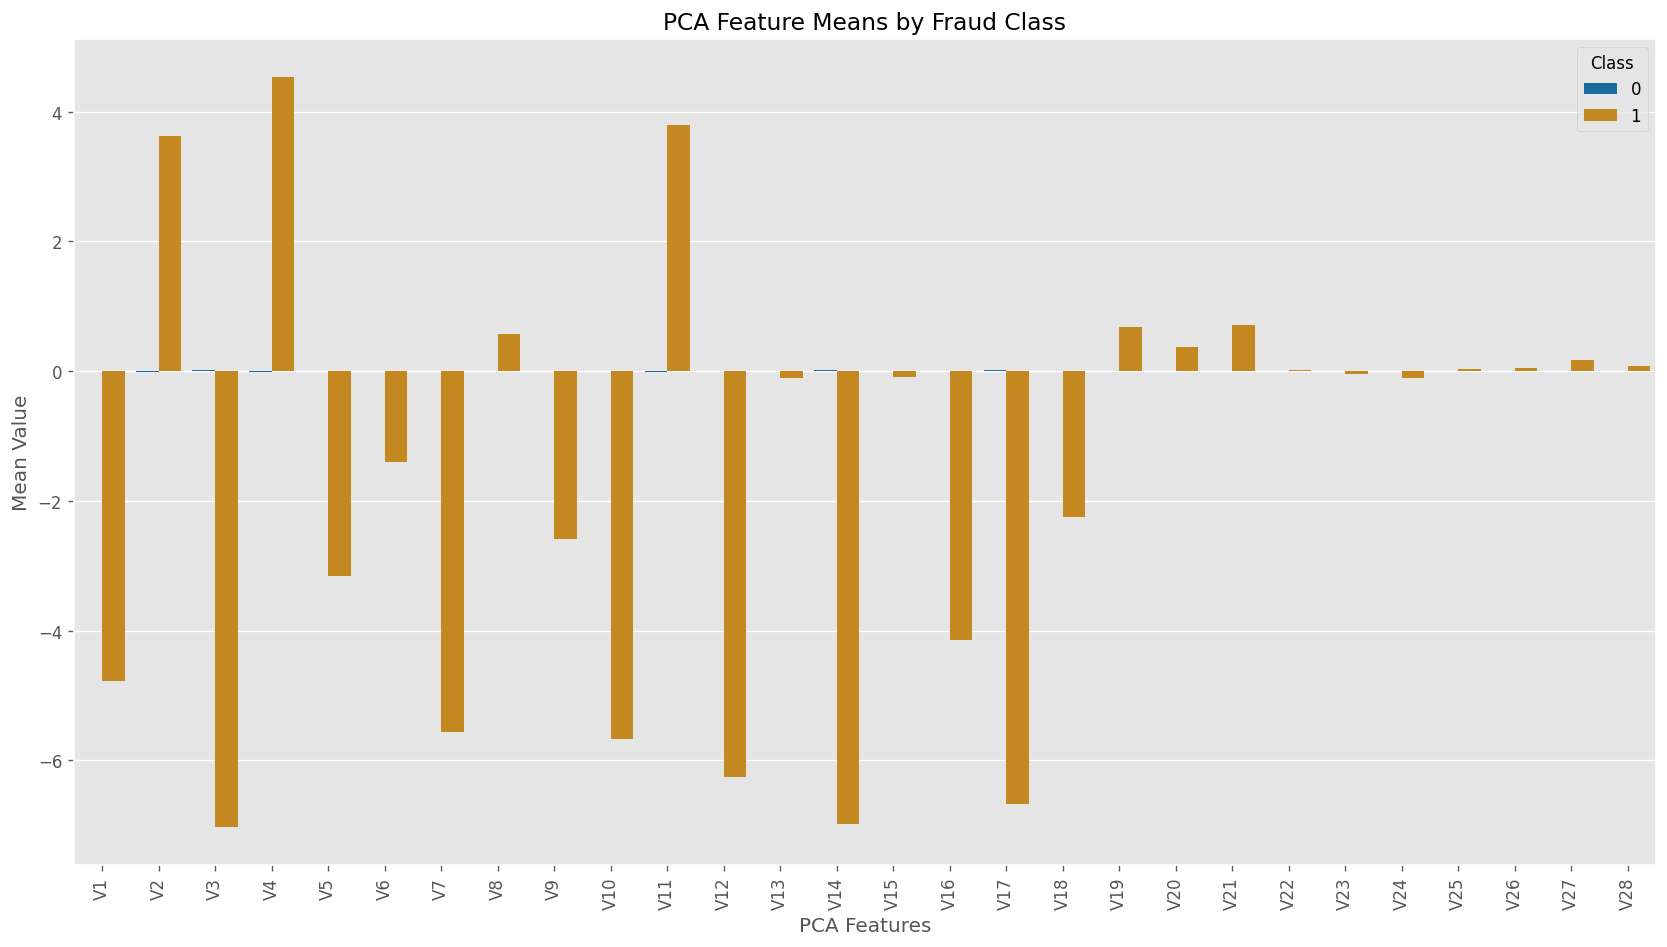

**Top Predictive PCA Features**: V3, V14, V17, V12, V10

C:\Users\estiphanos.h\AppData\Local\Temp\ipykernel_28176\1641104267.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=fraud_corrs.index, x=fraud_corrs.values, palette='viridis')


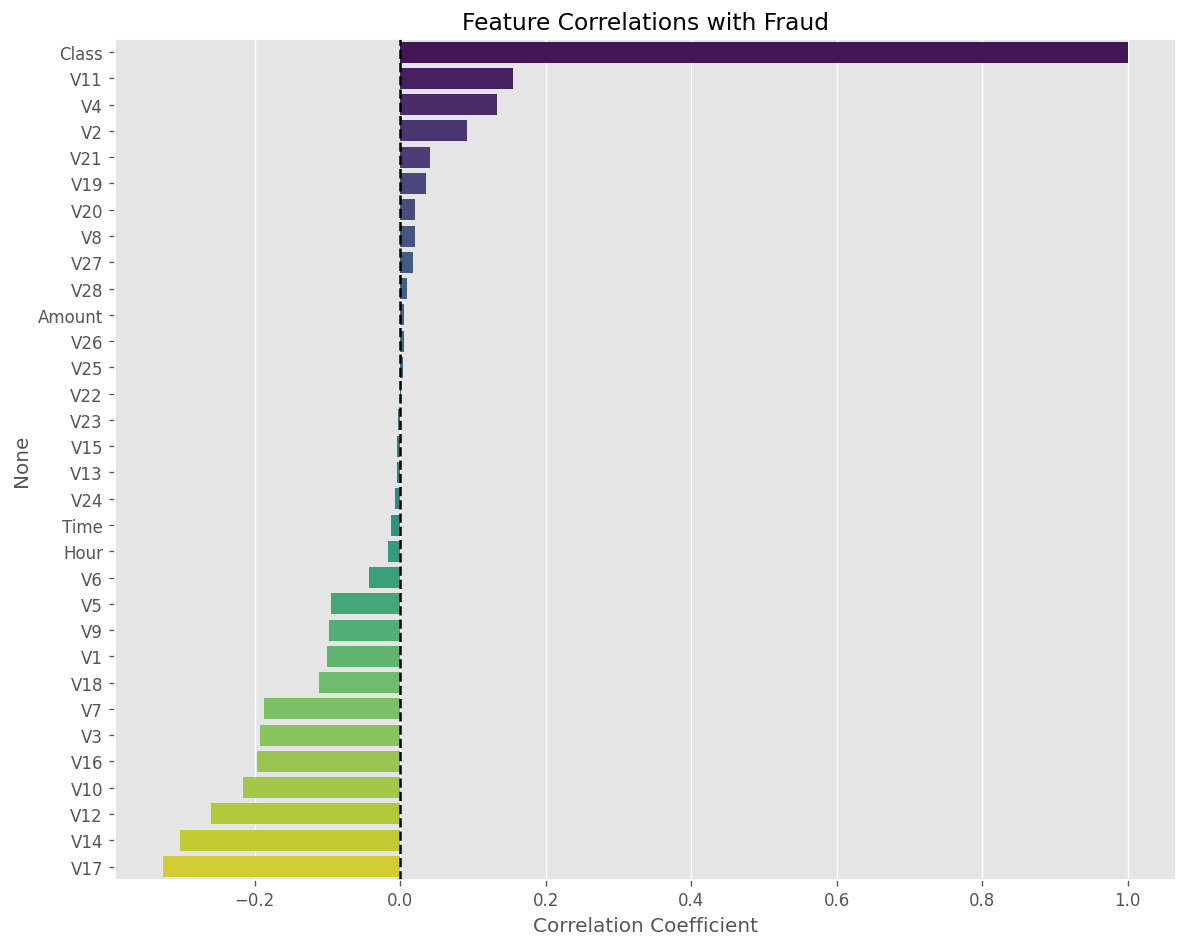

In [ ]:

# ### Load and Analyze Dataset
# +
# Load bank transaction data
bank = pd.read_csv('../data/raw/creditcard.csv')

print(f"Banking dataset shape: {bank.shape}")
display(bank.head(3))

# Target distribution
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=bank, x='Class', ax=ax[0])
ax[0].set_title('Fraud Class Distribution')
ax[0].set_xlabel('Fraud (1) vs Legitimate (0)')

fraud_pct_bank = bank['Class'].mean() * 100
ax[1].pie([100 - fraud_pct_bank, fraud_pct_bank], labels=['Legitimate', 'Fraud'], 
          autopct='%1.1f%%', startangle=90, colors=['#4c72b0', '#dd8452'])
ax[1].set_title(f'Fraud Percentage: {fraud_pct_bank:.4f}%')
plt.tight_layout()
plt.show()

display(Markdown(f"**Insight**: Banking fraud rate ({fraud_pct_bank:.4f}%) is significantly lower than e-commerce ({fraud_pct:.2f}%)"))
# -

# ### Time and Amount Analysis

# +
# Convert Time to hours
bank['Hour'] = bank['Time'] / 3600 % 24

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Fraud distribution by amount
sns.boxplot(data=bank, x='Class', y='Amount', ax=axes[0], showfliers=False)
axes[0].set_title('Transaction Amount by Fraud Status')
axes[0].set_yscale('log')

# Fraud rate by hour
hourly_bank = bank.groupby(['Hour', 'Class']).size().unstack()
hourly_bank['fraud_rate'] = hourly_bank[1] / (hourly_bank[0] + hourly_bank[1])
sns.lineplot(data=hourly_bank, x='Hour', y='fraud_rate', 
             ax=axes[1], color='#c44e52')
axes[1].set_title('Fraud Rate by Hour')
axes[1].set_ylabel('Fraud Rate')

# Amount vs time
sns.scatterplot(data=bank.sample(1000), x='Hour', y='Amount', 
                hue='Class', alpha=0.5, ax=axes[2])
axes[2].set_title('Transaction Amount vs Time')
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

display(Markdown("**Insight**: Banking fraud occurs more frequently during late night hours (1-5 AM) with typically smaller transaction amounts"))
# -

# ### PCA Feature Analysis

# +
# Calculate mean values for PCA features by class
pca_means = bank.groupby('Class').mean().iloc[:, 1:29].T.reset_index()
pca_means = pd.melt(pca_means, id_vars=['index'], 
                    value_vars=[0, 1], 
                    var_name='Class', 
                    value_name='Mean Value')

# Visualization
plt.figure(figsize=(14, 8))
sns.barplot(data=pca_means, x='index', y='Mean Value', hue='Class')
plt.title('PCA Feature Means by Fraud Class', fontsize=14)
plt.xlabel('PCA Features')
plt.ylabel('Mean Value')
plt.xticks(rotation=90)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

# Identify key features
feature_diffs = bank.groupby('Class').mean().iloc[:, 1:29].T
feature_diffs['diff'] = feature_diffs[1] - feature_diffs[0]
key_features = feature_diffs.sort_values('diff', key=abs, ascending=False).head(5).index.tolist()

display(Markdown(f"**Top Predictive PCA Features**: {', '.join(key_features)}"))
# -

# ### Correlation Analysis (Banking)

# +
# Calculate correlations
corr_matrix_bank = bank.corr(numeric_only=True)

# Focus on fraud correlations
fraud_corrs = corr_matrix_bank['Class'].sort_values(ascending=False)

# Visualization
plt.figure(figsize=(10, 8))
sns.barplot(y=fraud_corrs.index, x=fraud_corrs.values, palette='viridis')
plt.axvline(0, color='black', linestyle='--')
plt.title('Feature Correlations with Fraud', fontsize=14)
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()
# -

#  3. Cross-Domain Comparison

### Fraud Pattern Comparison

,Domain,Total Transactions,Fraud Percentage,Avg Fraud Amount,Peak Fraud Hours,Key Predictors
0,E-commerce,151112,9.365,36.993,10 PM - 4 AM,"time_since_signup, country, purchase_value"
1,Banking,284807,0.173,122.211,1 AM - 5 AM,"V14, V4, V10, Amount"


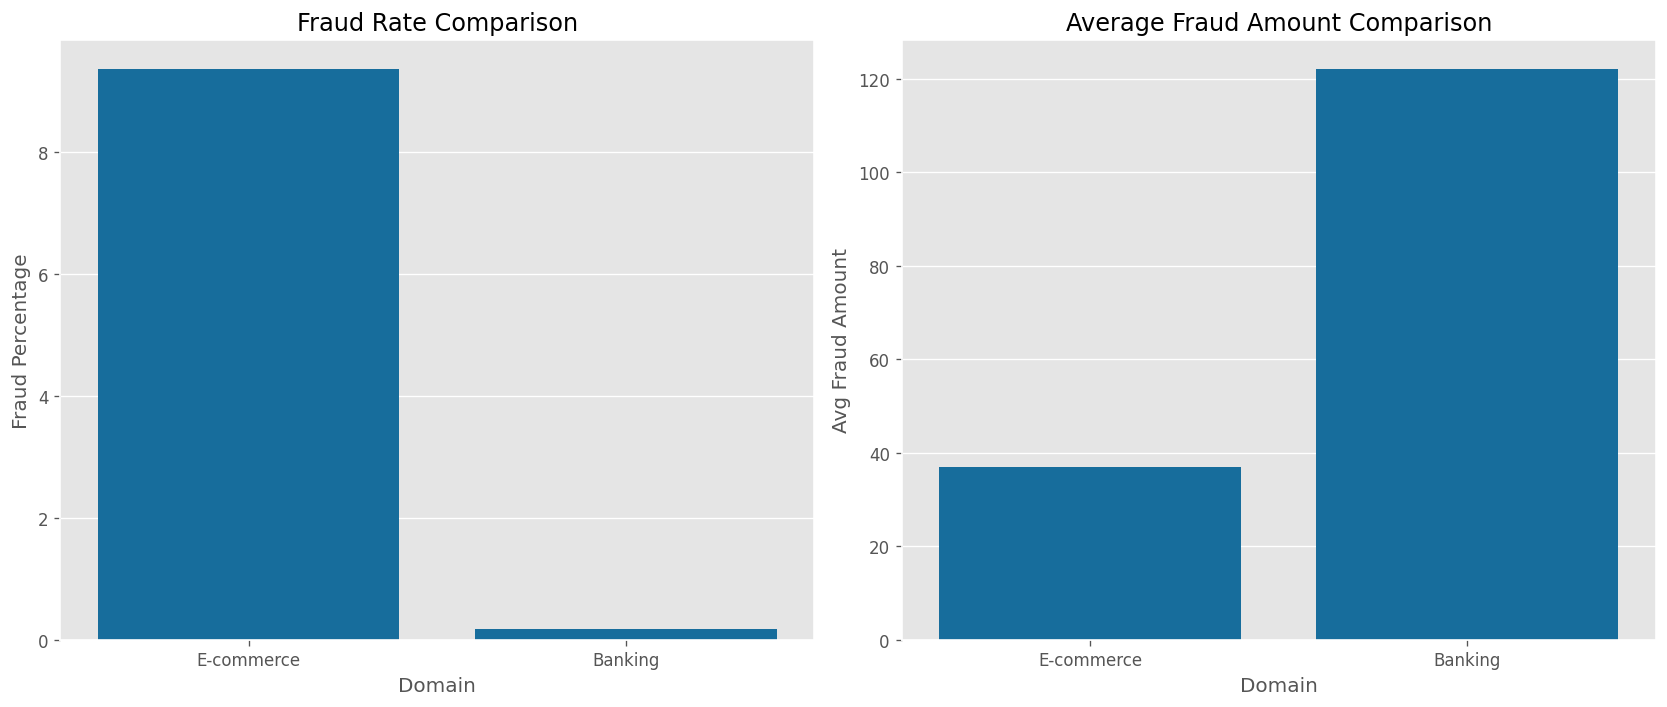

In [ ]:

# +
comparison = pd.DataFrame({
    'Domain': ['E-commerce', 'Banking'],
    'Total Transactions': [len(ecom), len(bank)],
    'Fraud Percentage': [fraud_pct, fraud_pct_bank],
    'Avg Fraud Amount': [
        ecom[ecom['class'] == 1]['purchase_value'].mean(),
        bank[bank['Class'] == 1]['Amount'].mean()
    ],
    'Peak Fraud Hours': ['10 PM - 4 AM', '1 AM - 5 AM'],
    'Key Predictors': [
        'time_since_signup, country, purchase_value', 
        'V14, V4, V10, Amount'
    ]
})

display(Markdown("### Fraud Pattern Comparison"))
display(comparison)

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Fraud rate comparison
sns.barplot(data=comparison, x='Domain', y='Fraud Percentage', ax=axes[0])
axes[0].set_title('Fraud Rate Comparison')

# Average fraud amount comparison
sns.barplot(data=comparison, x='Domain', y='Avg Fraud Amount', ax=axes[1])
axes[1].set_title('Average Fraud Amount Comparison')

plt.tight_layout()
plt.show()
# -